In [488]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

In [489]:
data=pd.read_csv('data.csv')

In [490]:
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [491]:
data = data.drop(columns=['country'])
data.corr()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
child_mort,1.000000,-0.318093,-0.200402,-0.127211,-0.524315,0.288276,-0.886676,0.848478,-0.483032
exports,-0.318093,1.000000,-0.114408,0.737381,0.516784,-0.107294,0.316313,-0.320011,0.418725
health,-0.200402,-0.114408,1.000000,0.095717,0.129579,-0.255376,0.210692,-0.196674,0.345966
imports,-0.127211,0.737381,0.095717,1.000000,0.122406,-0.246994,0.054391,-0.159048,0.115498
income,-0.524315,0.516784,0.129579,0.122406,1.000000,-0.147756,0.611962,-0.501840,0.895571
inflation,0.288276,-0.107294,-0.255376,-0.246994,-0.147756,1.000000,-0.239705,0.316921,-0.221631
life_expec,-0.886676,0.316313,0.210692,0.054391,0.611962,-0.239705,1.000000,-0.760875,0.600089
total_fer,0.848478,-0.320011,-0.196674,-0.159048,-0.501840,0.316921,-0.760875,1.000000,-0.454910
gdpp,-0.483032,0.418725,0.345966,0.115498,0.895571,-0.221631,0.600089,-0.454910,1.000000


In [492]:
data['export_value']=(data['exports']/100)*data['gdpp']
data['import_value']=(data['imports']/100)*data['gdpp']
data['health_value']=(data['health']/100)*data['gdpp']

In [493]:
data=data.drop(columns=['exports','imports','health'])

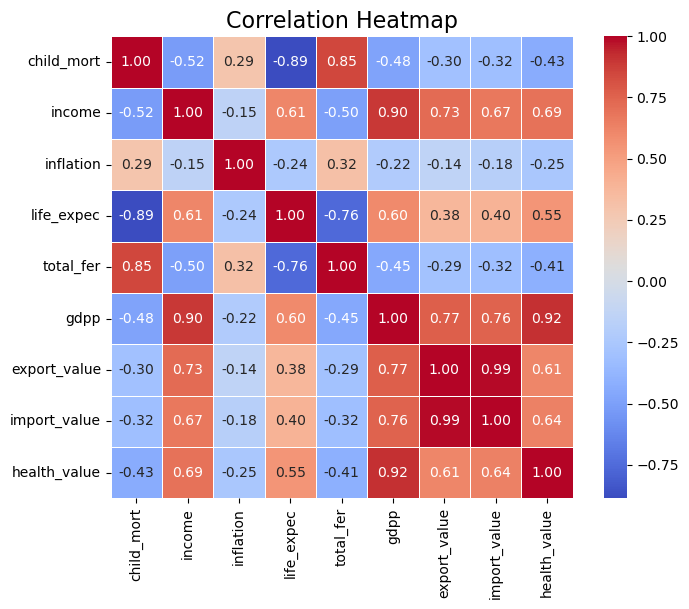

In [494]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    data.corr(),
    annot=True,            
    cmap='coolwarm',       
    fmt='.2f',             
    linewidths=0.5,        
    square=True            
)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

In [495]:
data=data.drop(columns=['gdpp','import_value','child_mort','total_fer'])

In [496]:
X = data.copy().values

In [497]:
def standardize(X):
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    return (X - mean) / std

X_scaled = standardize(X)

In [498]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

In [499]:
def init_centroids(X, k):
    np.random.seed(42)
    idx = np.random.choice(len(X), k, replace=False)
    return X[idx]

In [500]:
def assign_clusters(X, centroids):
    clusters = []
    for x in X:
        distances = [euclidean_distance(x, c) for c in centroids]
        clusters.append(np.argmin(distances))
    return np.array(clusters)

In [501]:
def update_centroids(X, clusters, k):
    new_centroids = []
    for i in range(k):
        points = X[clusters == i]
        new_centroids.append(points.mean(axis=0))
    return np.array(new_centroids)

In [502]:
def kmeans(X, k, max_iters=100):
    centroids = init_centroids(X, k)

    for _ in range(max_iters):
        clusters = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, clusters, k)

        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids

    return clusters, centroids

In [503]:
def compute_wcss(X, clusters, centroids):
    wcss = 0
    for i, c in enumerate(centroids):
        points = X[clusters == i]
        wcss += np.sum((points - c) ** 2)
    return wcss

In [504]:
wcss_values = []

for k in range(1, 8):
    clusters, centroids = kmeans(X_scaled, k)
    wcss = compute_wcss(X_scaled, clusters, centroids)
    wcss_values.append(wcss)

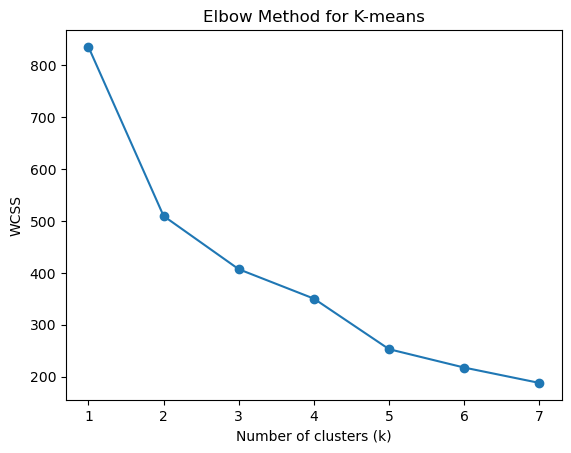

In [505]:
plt.figure()
plt.plot(range(1, 8), wcss_values, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method for K-means")
plt.show()

In [506]:
k = 3
clusters, centroids = kmeans(X_scaled, k)

In [507]:
df['cluster'] = clusters

In [508]:
cov = np.cov(X_scaled, rowvar=False)
eigvals, eigvecs = np.linalg.eigh(cov)
idx = np.argsort(eigvals)[::-1]
W = eigvecs[:, idx[:2]]
X_pca = X_scaled @ W


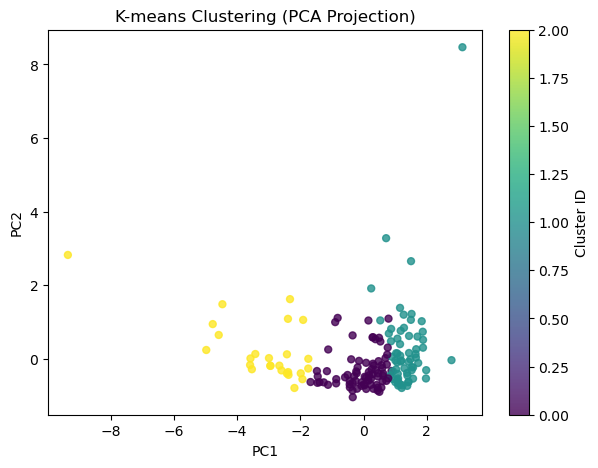

In [509]:
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1],
            c=clusters, cmap='viridis',
            s=25, alpha=0.8)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-means Clustering (PCA Projection)")
plt.colorbar(label="Cluster ID")
plt.show()


In [510]:
def silhouette_score(X, labels):
    n = len(X)
    unique_clusters = np.unique(labels)
    silhouette_vals = []

    for i in range(n):
        same_cluster = X[labels == labels[i]]
        other_clusters = [X[labels == c] for c in unique_clusters if c != labels[i]]

        if len(same_cluster) > 1:
            a = np.mean([euclidean_distance(X[i], x) for x in same_cluster if not np.array_equal(x, X[i])])
        else:
            a = 0

        b = np.inf
        for cluster in other_clusters:
            mean_dist = np.mean([euclidean_distance(X[i], x) for x in cluster])
            b = min(b, mean_dist)


        s = (b - a) / max(a, b) if max(a, b) != 0 else 0
        silhouette_vals.append(s)

    return np.mean(silhouette_vals)

In [511]:
score = silhouette_score(X_scaled, clusters)
print("Silhouette Score:", score)

Silhouette Score: 0.34078218380137254


In [512]:
cluster_summary = (
    df
    .drop(columns=['kmeans_cluster'])
    .groupby('cluster')
    .mean(numeric_only=True)
)

cluster_summary

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster,,,,,,,,,
0,16.635065,42.501299,6.508961,46.998701,16098.441558,5.519091,74.851948,2.116753,9590.623377
1,77.754688,30.721859,6.287031,44.438530,4452.859375,12.380547,61.353125,4.418906,2200.562500
2,5.150000,62.553846,9.025385,52.603846,51484.615385,3.163115,80.484615,1.788846,49450.000000


In [513]:
df['cluster'] = clusters

In [514]:
for c in sorted(df['cluster'].unique()):
    print(f"\nCluster {c}:")
    print(df[df['cluster'] == c]['country'].values)


Cluster 0:
['Albania' 'Algeria' 'Antigua and Barbuda' 'Argentina' 'Armenia'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belize' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Brazil' 'Bulgaria'
 'Cape Verde' 'Chile' 'China' 'Colombia' 'Costa Rica' 'Croatia' 'Cyprus'
 'Czech Republic' 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador'
 'Estonia' 'Georgia' 'Greece' 'Grenada' 'Guatemala' 'Hungary' 'Iran'
 'Israel' 'Jamaica' 'Jordan' 'Latvia' 'Lebanon' 'Libya' 'Lithuania'
 'Macedonia, FYR' 'Malaysia' 'Maldives' 'Mauritius' 'Montenegro' 'Morocco'
 'Oman' 'Panama' 'Paraguay' 'Peru' 'Philippines' 'Poland' 'Portugal'
 'Romania' 'Russia' 'Samoa' 'Saudi Arabia' 'Serbia' 'Seychelles'
 'Slovak Republic' 'Slovenia' 'South Korea' 'Spain' 'Sri Lanka'
 'St. Vincent and the Grenadines' 'Suriname' 'Thailand' 'Tonga' 'Tunisia'
 'Turkey' 'Turkmenistan' 'Ukraine' 'Uruguay' 'Vietnam']

Cluster 1:
['Afghanistan' 'Angola' 'Benin' 'Botswana' 'Burkina Faso' 'Burundi'
 'Cambodia' 'Came